In [1]:
#pip install ee

In [2]:
#pip install geemap

# Import Libraries

In [3]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO

#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [4]:
# DOC DATA 
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L','SITE_ID', 'DATE_SMP'])

# Read the "Site Information" Excel sheet to get the mapping between lake names and SITE_ID
site_info_df = pd.read_excel('Site_Information_2022_8_1 (2).xlsx', usecols=['SITE_ID', 'PROGRAM_ID', 'LAKE_DEPTH_MEAN', 'SITE_NAME'])


# PROF. Coordinates 
data_path = 'ALTM-50-stations.xlsx'
df_lake_info = pd.read_excel(data_path, sheet_name='updated station coordinates', usecols=['SITE_ID', 'SITE_NAME','LATDD_CENT', 'LONDD_CENT'])


merge_data = pd.merge(data_doc, site_info_df, on='SITE_ID')
merge_data = pd.merge(merge_data, df_lake_info, on= ['SITE_ID', 'SITE_NAME'])

data_modify = merge_data[merge_data['PROGRAM_ID']=='LTM_ALTM']

In [5]:
data_modify

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT
0,040850,1997-09-22,3.100000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
2,040850,1995-03-02,3.031000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
4,040850,1996-08-19,3.595000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
6,040850,2003-11-06,4.232000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
8,040850,2005-07-11,3.344000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
...,...,...,...,...,...,...,...,...
17863,1A3-048,2011-05-18,4.283944,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17864,1A3-048,2015-06-10,5.509394,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17865,1A3-048,2016-07-14,4.884900,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17866,1A3-048,2016-09-15,6.344000,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172


# REFLECTANCE data prep

In [6]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


Map= geemap.Map()

# Authenticate and initialize the Earth Engine API
#ee.Authenticate()  # Only needed for the first time
ee.Initialize()

# Create a list of lake names
lake_names = [
    'Little Hope Pond', 'Big Hope Pond', 'East Copperas Pond', 'Sunday Pond', 'Sochia Pond',
    'Grass Pond (3)', 'Little Clear Pond', 'Loon Hollow Pond', 'Willys Lake', 'Woods Lake',
    'Middle Settlement Lake', 'Middle Branch Lake', 'Limekiln Lake', 'Squaw Lake', 'Indian Lake',
    'Brook Trout Lake', 'Lost Pond', 'North Lake', 'Willis Lake', 'Long Pond', 'Carry Pond',
    'Lake Colden', 'Avalanche Lake', 'Little Simon Pond', 'Raquette Lake Reservoir', 'G Lake',
    'Constable Pond', 'Middle Pond', 'Arbutus Pond', 'Sagamore Lake', 'Black Pond', 'Windfall Pond',
    'Queer Lake', 'Heart Lake', 'Big Moose Lake', 'Cascade Lake', 'Dart Lake', 'Little Echo Pond',
    'Moss Lake', 'Lake Rondaxe', 'Squash Pond', 'West Pond', 'Owen Pond', 'Jockeybush Lake',
    'Barnes Lake', 'Clear Pond', 'Otter Lake', 'Nate Pond', 'Grass Pond', 'South Lake (East Branch)'
]

sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

# Define the function to mask clouds and cloud shadows from Landsat 5 surface reflectance imagery
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage


# Define the function to compute the mean reflectance values for the specified bands within the region of interest (lake)
def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)

# Initialize an empty list to store the dataframes for each lake
dfs = []

# Loop through each lake name and retrieve Landsat 5 imagery for that lake
for SITE_NAME in lake_names:
    # Retrieve Landsat 5 imagery for the specific lake
    lake = ee.FeatureCollection('projects/ee-touhedakhanom14/assets/stations-coord')\
        .filter(ee.Filter.eq('SITE_NAME', SITE_NAME))
    

    Map.addLayer(lake, {'color': 'red'})  # Adding the original point to show the difference

    
    
    s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(2019, 2023, 'year')) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES)\
    .filterBounds(lake) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))

    # Map the reflectance function over the Landsat 5 ImageCollection for the specific lake
    map_reflectance = s2.map(lambda img: reflectance(img, lake))

    # Reduce the mapped image collection to get reflectance values for the specific lake
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a pandas DataFrame
    df_reflectance = pd.DataFrame(list_reflectance.getInfo(), columns=['DATE_SMP', 'reflectance'])
    df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
    df_reflectance['DATE_SMP'] = df_reflectance['DATE_SMP'].dt.date
    df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v/10000 for k, v in x.items() if v is not None})

    # Unpack the 'reflectance' dictionary and create separate columns for each band
    df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                                df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')], axis=1)

    # Add a new column for the lake name
    df_reflectance['SITE_NAME'] = SITE_NAME

    # Add the DataFrame to the list
    dfs.append(df_reflectance)

# Concatenate all DataFrames into a single DataFrame
df_all_lakes = pd.concat(dfs, ignore_index=True)

# Sort the DataFrame by 'DATE_SMP' in ascending order
df_all_lakes.sort_values(by='DATE_SMP', inplace=True)


Map.centerObject(lake, 10)
Map
# Display the DataFrame containing reflectance values for all lakes with separate columns for each lake
# print(df_all_lakes)


Map(center=[43.50986135214135, -74.8826739109505], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1,SITE_NAME
756,2019-01-04,0.8181,0.8262,0.7607,0.5595,0.6992,0.6896,0.6426,0.6591,0.0711,Loon Hollow Pond
5849,2019-01-04,0.8717,0.9142,0.9262,0.8625,0.9248,0.9573,0.9199,0.8928,0.0639,Barnes Lake
6079,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clear Pond
6543,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Lake (East Branch)
6542,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Lake (East Branch)
...,...,...,...,...,...,...,...,...,...,...,...
6077,2023-07-19,0.1194,0.1228,0.1247,0.1233,0.1153,0.1172,0.1208,0.1225,0.1086,Barnes Lake
3081,2023-07-19,0.3763,0.3952,0.4058,0.5910,0.4035,0.4419,0.5368,0.5784,0.4979,Little Simon Pond
5612,2023-07-19,1.0965,1.0982,1.0580,1.0159,1.0544,1.1112,1.0667,1.0576,0.7273,Owen Pond
6078,2023-07-22,0.1558,0.1596,0.1640,0.1660,0.1589,0.1660,0.1674,0.1557,0.1546,Barnes Lake


In [8]:
df_all_lakes.dropna(inplace=True)


In [9]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1,SITE_NAME
756,2019-01-04,0.8181,0.8262,0.7607,0.5595,0.6992,0.6896,0.6426,0.6591,0.0711,Loon Hollow Pond
5849,2019-01-04,0.8717,0.9142,0.9262,0.8625,0.9248,0.9573,0.9199,0.8928,0.0639,Barnes Lake
2856,2019-01-11,0.1862,0.1273,0.0863,0.0373,0.0550,0.0328,0.0622,0.0695,0.0049,Avalanche Lake
6317,2019-01-11,0.4772,0.8468,0.8359,0.8590,0.8563,0.9075,0.8903,0.9080,0.1668,Nate Pond
5283,2019-01-11,0.5388,0.6845,0.6699,0.6771,0.6757,0.6511,0.6903,0.7537,0.1192,West Pond
...,...,...,...,...,...,...,...,...,...,...,...
1970,2023-07-19,0.1215,0.1187,0.1137,0.1137,0.1100,0.1117,0.1103,0.1160,0.1121,Indian Lake
6077,2023-07-19,0.1194,0.1228,0.1247,0.1233,0.1153,0.1172,0.1208,0.1225,0.1086,Barnes Lake
3081,2023-07-19,0.3763,0.3952,0.4058,0.5910,0.4035,0.4419,0.5368,0.5784,0.4979,Little Simon Pond
5612,2023-07-19,1.0965,1.0982,1.0580,1.0159,1.0544,1.1112,1.0667,1.0576,0.7273,Owen Pond


In [10]:
pd.set_option('display.max_rows', None)
print(df_all_lakes)

        DATE_SMP  Aerosols    Blue   Green     NIR     Red  RedEdge1  \
756   2019-01-04    0.8181  0.8262  0.7607  0.5595  0.6992    0.6896   
5849  2019-01-04    0.8717  0.9142  0.9262  0.8625  0.9248    0.9573   
2856  2019-01-11    0.1862  0.1273  0.0863  0.0373  0.0550    0.0328   
6317  2019-01-11    0.4772  0.8468  0.8359  0.8590  0.8563    0.9075   
5283  2019-01-11    0.5388  0.6845  0.6699  0.6771  0.6757    0.6511   
5284  2019-01-11    0.4817  0.6191  0.6077  0.6296  0.6183    0.5998   
2523  2019-01-11    0.4257  0.5577  0.5187  0.4813  0.4875    0.5089   
5850  2019-01-11    1.1755  1.1942  1.1628  1.0551  1.1614    1.1546   
4840  2019-01-11    0.7205  0.7277  0.6671  0.5938  0.6506    0.6407   
5614  2019-01-11    0.3128  0.2223  0.1727  0.1826  0.1479    0.1472   
5613  2019-01-11    0.3255  0.2270  0.1744  0.1817  0.1480    0.1483   
1529  2019-01-11    0.4232  0.6304  0.5595  0.4543  0.5148    0.5329   
2413  2019-01-11    0.4913  0.8326  0.8100  0.7237  0.8224    0.

In [11]:
df_all_lakes['DATE_SMP'] = pd.to_datetime(df_all_lakes['DATE_SMP'])
data_modify['DATE_SMP'] = pd.to_datetime(data_modify['DATE_SMP'])

In [12]:
data_modify.sort_values('DATE_SMP', inplace=True)
df_all_lakes.sort_values('DATE_SMP', inplace=True)


In [13]:
# Create the 3-day time window
window_size = pd.Timedelta(days=3)

# Merge data within the 3-day time window

merged_data = pd.merge_asof(data_modify, df_all_lakes, on='DATE_SMP', by='SITE_NAME', tolerance=window_size)

In [14]:
merged_data = merged_data.dropna(subset=['Blue'])

In [15]:
merged_data = merged_data.dropna(subset=['LAKE_DEPTH_MEAN'])

In [16]:
merged_data

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT,Aerosols,Blue,Green,NIR,Red,RedEdge1,RedEdge2,RedEdge4,SWIR1
15284,040186,2019-02-28,8.126200,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,1.2071,1.1988,1.1221,1.0054,1.1152,1.1127,1.0845,1.1098,0.1499
15291,1A3-065,2019-04-01,4.190400,LTM_ALTM,South Lake (East Branch),8.3,43.51165,-74.88815,0.6755,1.0456,1.0393,0.9754,1.0628,1.0771,1.0456,1.0896,0.1452
15295,1A1-112,2019-04-03,7.457600,LTM_ALTM,West Pond,1.5,43.81102,-74.87937,0.5512,0.6703,0.6905,0.7846,0.6995,0.7467,0.7533,0.8659,0.1494
15304,040186,2019-04-04,8.023800,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,0.9155,0.9114,0.8678,0.7803,0.8702,0.8766,0.8547,0.8430,0.0270
15318,1A2-077,2019-04-16,4.902200,LTM_ALTM,Clear Pond,9.2,43.99719,-73.82435,0.4859,0.6954,0.6822,0.5689,0.6720,0.6900,0.6555,0.5826,0.0317
15319,1A1-105,2019-04-17,5.148900,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.4133,0.3416,0.3379,0.1577,0.3174,0.3111,0.2495,0.1917,0.0222
15329,050706,2019-05-06,5.574700,LTM_ALTM,Lake Colden,2.3,44.12266,-73.97953,0.0237,0.0186,0.0184,0.0317,0.0154,0.0185,0.0239,0.0240,0.0185
15330,1A1-102,2019-05-06,2.644700,LTM_ALTM,Heart Lake,5.1,44.18229,-73.96920,0.0312,0.0273,0.0309,0.0158,0.0203,0.0162,0.0067,0.0150,0.0194
15331,050707,2019-05-06,6.453600,LTM_ALTM,Avalanche Lake,3.3,44.13287,-73.96681,0.0534,0.0532,0.0589,0.2383,0.0589,0.0852,0.1667,0.2095,0.1023
15338,1A1-105,2019-05-09,4.361700,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.0301,0.0212,0.0180,0.0098,0.0122,0.0114,0.0090,0.0114,0.0146


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Preparing the training data
X_train = merged_data[['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1','LAKE_DEPTH_MEAN']]  # Features 
y_train = merged_data['DOC_MG_L']  # Target variable

# Split the dataset into training and testing sets where 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Train the Random Forest Regressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict DOC values for both training and testing data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)



# Create DataFrames for the training and testing data with all bands and the predicted values
data_train = pd.DataFrame(X_train, columns=['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1','LAKE_DEPTH_MEAN'])

# data_train = pd.DataFrame(X_train, columns=['blue', 'green', 'red', 'nir,'LAKE_DEPTH_MEAN'])
data_train['original_DOC'] = y_train
data_train['predicted_DOC'] = y_pred_train

data_test = pd.DataFrame(X_test, columns=['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1','LAKE_DEPTH_MEAN'])
data_test['original_DOC'] = y_test
data_test['predicted_DOC'] = y_pred_test


In [18]:
# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data***************')
data_train

*************Predicted Training data***************


,Aerosols,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge4,NIR,SWIR1,LAKE_DEPTH_MEAN,original_DOC,predicted_DOC
15515,0.1399,0.1380,0.1481,0.1367,0.1846,0.2453,0.2582,0.2770,0.2177,2.8,5.587261,5.796015
15774,0.0664,0.0621,0.0528,0.0379,0.0447,0.0616,0.0540,0.0534,0.0130,5.8,8.268000,7.264625
15338,0.0301,0.0212,0.0180,0.0122,0.0114,0.0090,0.0114,0.0098,0.0146,4.2,4.361700,4.477948
15441,0.0045,0.0130,0.0180,0.0098,0.0086,0.0030,0.0097,0.0081,0.0065,5.1,2.770000,3.610965
15401,0.0153,0.0096,0.0102,0.0084,0.0111,0.0091,0.0201,0.0209,0.0172,2.3,6.477600,6.223487
15536,0.0415,0.0321,0.0383,0.0231,0.0624,0.1496,0.1652,0.2020,0.1072,1.6,14.460157,11.531678
15427,0.0064,0.0147,0.0261,0.0230,0.0423,0.1248,0.1609,0.1957,0.0787,3.3,7.944500,7.020476
15771,0.0830,0.0794,0.0720,0.0510,0.0639,0.1011,0.0984,0.0978,0.0257,5.5,7.293800,7.317980
15563,0.0212,0.0210,0.0324,0.0277,0.0577,0.1036,0.1342,0.1381,0.0897,0.7,10.660516,9.953957
15319,0.4133,0.3416,0.3379,0.3174,0.3111,0.2495,0.1917,0.1577,0.0222,4.2,5.148900,6.077145


In [19]:
print(f'*************Predicted Testing data***************')

data_test


*************Predicted Testing data***************


,Aerosols,Blue,Green,Red,RedEdge1,RedEdge2,RedEdge4,NIR,SWIR1,LAKE_DEPTH_MEAN,original_DOC,predicted_DOC
15499,0.8771,1.0551,1.0290,1.0198,1.0496,1.0354,1.0389,0.9512,0.1546,5.5,6.745973,7.389073
15508,0.2744,0.2624,0.2473,0.2347,0.2250,0.2308,0.2431,0.2294,0.0288,2.3,4.682251,7.152081
15318,0.4859,0.6954,0.6822,0.6720,0.6900,0.6555,0.5826,0.5689,0.0317,9.2,4.902200,5.495687
15518,0.1945,0.1846,0.1705,0.1641,0.1934,0.2187,0.2065,0.2428,0.2280,8.3,3.686040,4.331004
15413,0.3224,0.1549,0.2027,0.2429,0.2782,0.3470,0.2571,0.4068,0.2586,3.0,4.772000,7.555632
15529,0.0233,0.0192,0.0196,0.0168,0.0233,0.0232,0.0271,0.0288,0.0217,1.5,4.499849,7.927881
15540,0.0182,0.0132,0.0147,0.0107,0.0153,0.0159,0.0193,0.0255,0.0209,2.3,5.467659,5.558329
15346,0.0709,0.0878,0.0879,0.0854,0.0974,0.1133,0.1377,0.1183,0.1143,2.9,10.358000,6.170665
15474,0.0004,0.0018,0.0014,0.0012,0.0005,0.0001,0.0013,0.0026,0.0021,8.3,4.257446,12.399922
15687,0.0119,0.0084,0.0070,0.0076,0.0073,0.0090,0.0090,0.0071,0.0083,3.0,5.523300,8.963830


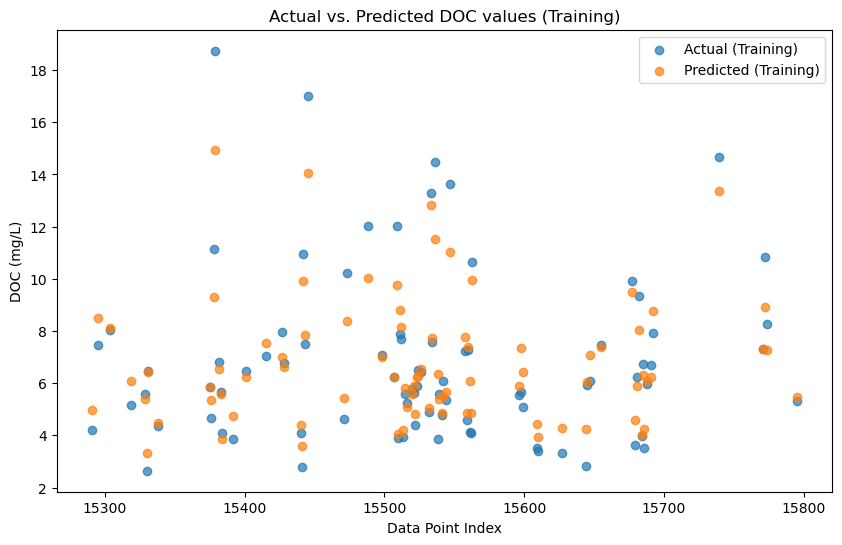

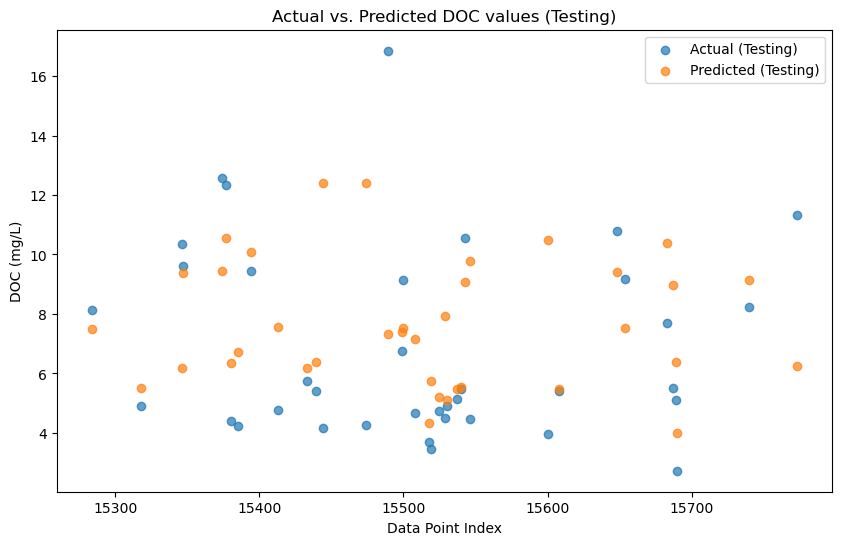

In [20]:
import matplotlib.pyplot as plt

# Plotting the training data
plt.figure(figsize=(10, 6))
plt.scatter(data_train.index, data_train['original_DOC'], label='Actual (Training)', alpha=0.7)
plt.scatter(data_train.index, data_train['predicted_DOC'], label='Predicted (Training)', alpha=0.7)
plt.xlabel('Data Point Index')
plt.ylabel('DOC (mg/L)')
plt.title('Actual vs. Predicted DOC values (Training)')
plt.legend()
plt.show()

# Plotting the testing data
plt.figure(figsize=(10, 6))
plt.scatter(data_test.index, data_test['original_DOC'], label='Actual (Testing)', alpha=0.7)
plt.scatter(data_test.index, data_test['predicted_DOC'], label='Predicted (Testing)', alpha=0.7)
plt.xlabel('Data Point Index')
plt.ylabel('DOC (mg/L)')
plt.title('Actual vs. Predicted DOC values (Testing)')
plt.legend()
plt.show()


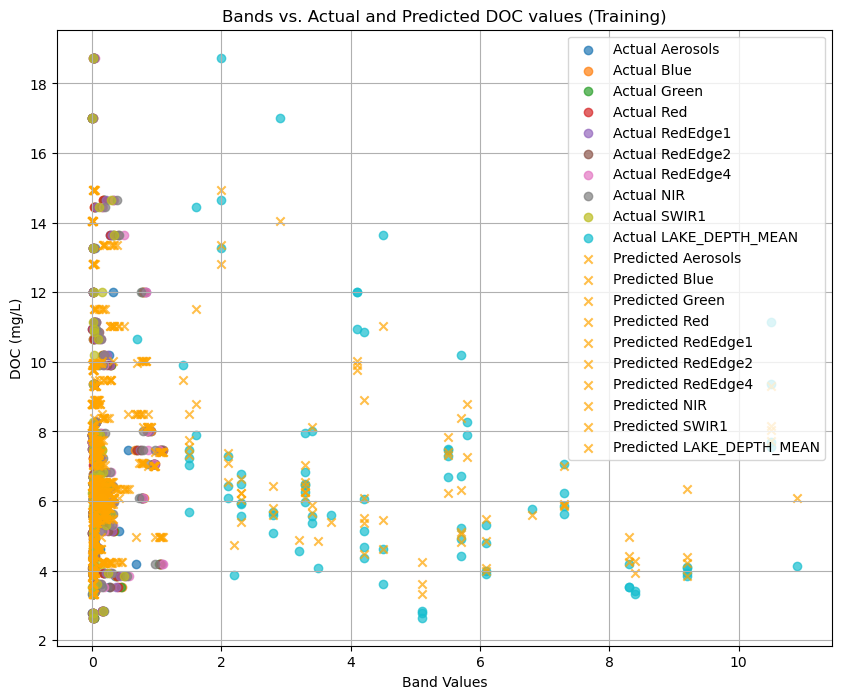

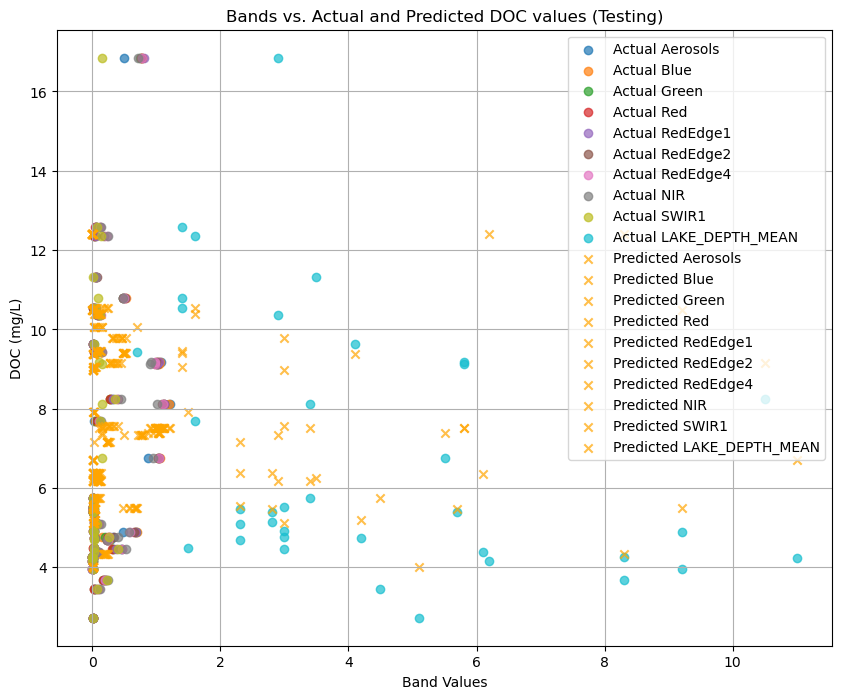

In [31]:
import matplotlib.pyplot as plt

# List of bands
bands = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']

# Create a single plot
plt.figure(figsize=(10, 8))

# Plot actual DOC values for each band
for band in bands:
    plt.scatter(data_train[band], data_train['original_DOC'], label=f'Actual {band}', alpha=0.7)

# Plot predicted DOC values for each band
for band in bands:
    plt.scatter(data_train[band], data_train['predicted_DOC'], label=f'Predicted {band}', alpha=0.7, marker='x', color='orange')

plt.xlabel('Band Values')
plt.ylabel('DOC (mg/L)')
plt.title('Bands vs. Actual and Predicted DOC values (Training)')
plt.legend()
plt.grid(True)
plt.show()

# Create a single plot
plt.figure(figsize=(10, 8))

# Plot actual DOC values for each band in testing data
for band in bands:
    plt.scatter(data_test[band], data_test['original_DOC'], label=f'Actual {band}', alpha=0.7)

# Plot predicted DOC values for each band in testing data
for band in bands:
    plt.scatter(data_test[band], data_test['predicted_DOC'], label=f'Predicted {band}', alpha=0.7, marker='x', color='orange')

plt.xlabel('Band Values')
plt.ylabel('DOC (mg/L)')
plt.title('Bands vs. Actual and Predicted DOC values (Testing)')
plt.legend()
plt.grid(True)
plt.show()



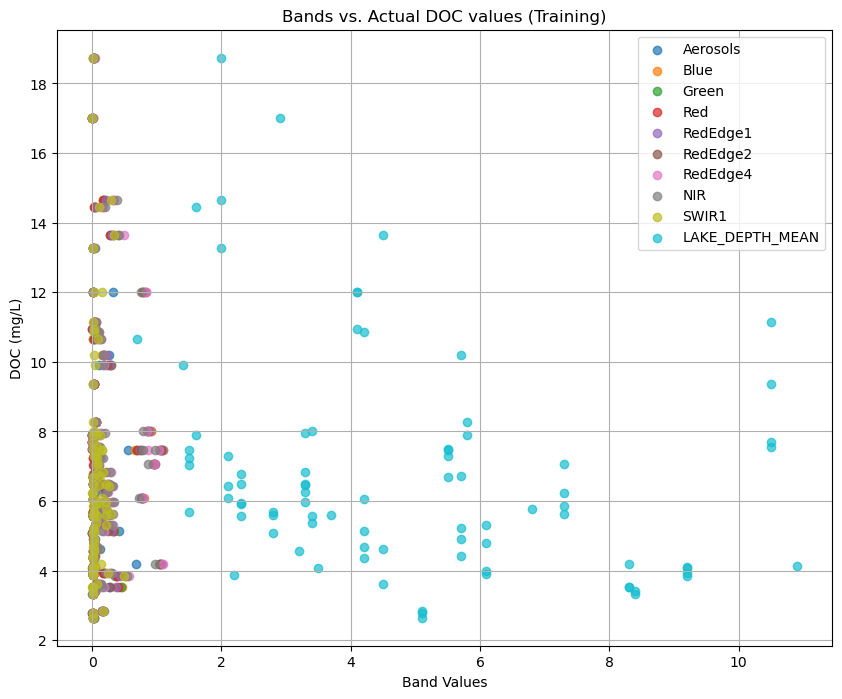

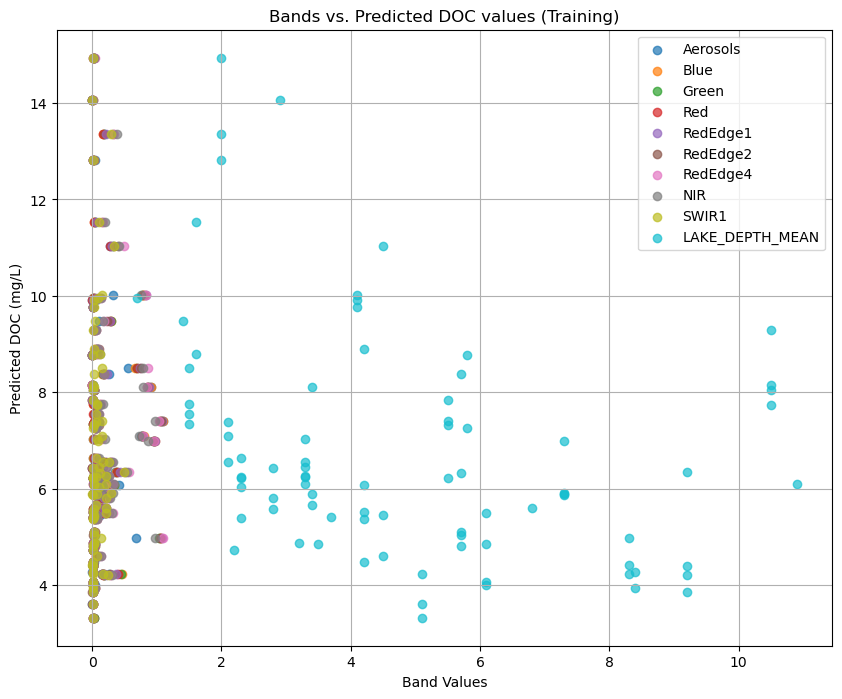

In [34]:
import matplotlib.pyplot as plt

# List of bands
bands = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']

# Create a single plot
plt.figure(figsize=(10, 8))

# Plot actual DOC values for each band
for band in bands:
    plt.scatter(data_train[band], data_train['original_DOC'], label=band, alpha=0.7)

plt.xlabel('Band Values')
plt.ylabel('DOC (mg/L)')
plt.title('Bands vs. Actual DOC values (Training)')
plt.legend()
plt.grid(True)
plt.show()


# Create a single plot
plt.figure(figsize=(10, 8))

# Plot predicted DOC values for each band in training data
for band in bands:
    plt.scatter(data_train[band], data_train['predicted_DOC'], label=band, alpha=0.7)

plt.xlabel('Band Values')
plt.ylabel('Predicted DOC (mg/L)')
plt.title('Bands vs. Predicted DOC values (Training)')
plt.legend()
plt.grid(True)
plt.show()



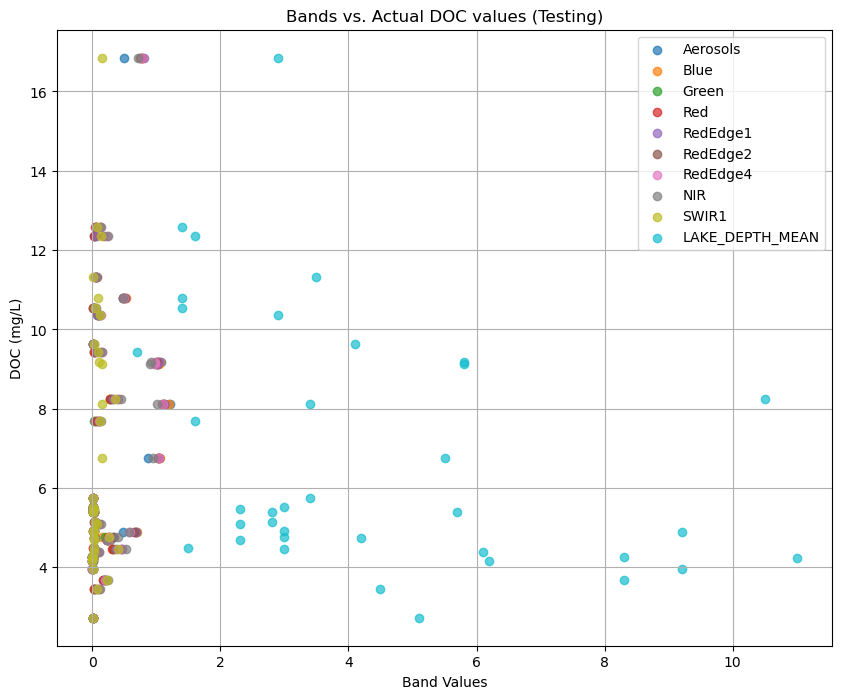

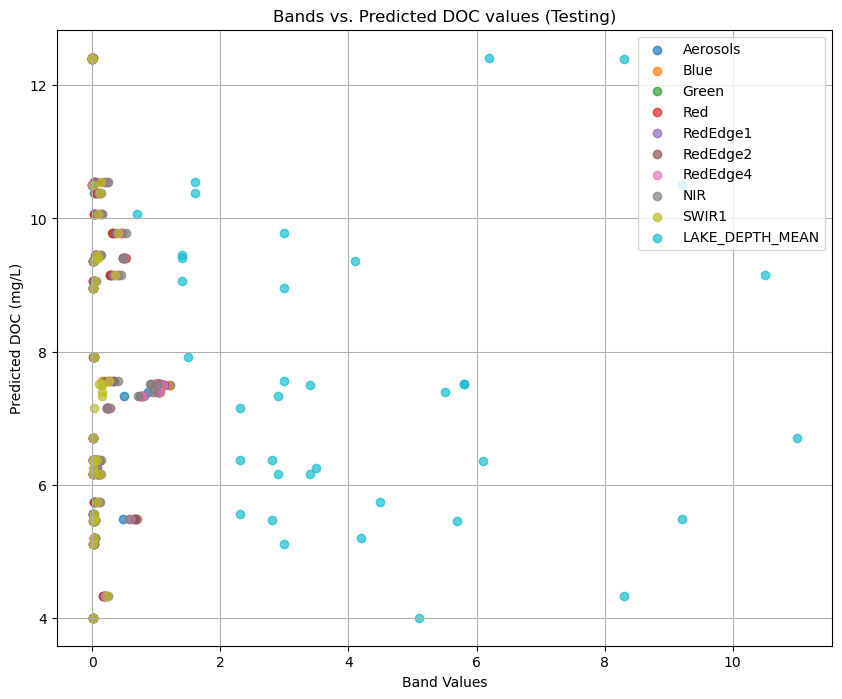

In [38]:
import matplotlib.pyplot as plt

# List of bands
bands = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge4', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']

# Create a single plot for the testing data
plt.figure(figsize=(10, 8))

# Plot actual DOC values for each band in testing data
for band in bands:
    plt.scatter(data_test[band], data_test['original_DOC'], label=band, alpha=0.7)

plt.xlabel('Band Values')
plt.ylabel('DOC (mg/L)')
plt.title('Bands vs. Actual DOC values (Testing)')
plt.legend()
plt.grid(True)
plt.show()


# Create a single plot for the testing data
plt.figure(figsize=(10, 8))

# Plot predicted DOC values for each band in testing data
for band in bands:
    plt.scatter(data_test[band], data_test['predicted_DOC'], label=band, alpha=0.7)

plt.xlabel('Band Values')
plt.ylabel('Predicted DOC (mg/L)')
plt.title('Bands vs. Predicted DOC values (Testing)')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Calculate the Mean Squared Error (MSE) for the testing data
mse_test = mean_squared_error(y_test, y_pred_test)

#MSE assesses the average squared difference between the observed and predicted values.

# Print the MSE for the testing data
print("Mean Squared Error (Testing):", mse_test)

#Mean Squared Error (Testing): 11.599018859844517


Mean Squared Error (Testing): 11.599018859844517
